In [32]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import warnings
from PIL import Image
import matplotlib.patches as patches
import random

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import applications
from tensorflow.keras.applications import Xception, VGG16
from tensorflow.keras.applications.xception import preprocess_input

warnings.filterwarnings("ignore")
from utils.delf import image_input_fn,  get_features, match_images, get_delf_features_inliners_coordinates

# Landmark Recognition

## Author: Svetlana Topalova

### Abstract

In this project we will be solving an image classification problem, where our goal will be to tell which class the input image belongs to. The way we are going to achieve it is by training an artificial neural network on few thousand images of 25 landmarks and make the NN(Neural Network) learn to predict the image class.

### Overview



### Data exploration

Image dataset comes from https://archive.codeplex.com/?p=landmark3d and contains:
- 25 landmarks
- 45,180 database images (1.4K~2K per landmark) 
- 10,000 positive test images for evaluation (400 per landmark)

Script for downloading:

$ python3 utils/download_data.py 'train'

$ python3 utils/download_data.py 'validation'

After downloading the dataset we have two folders: train and validation. Each folder contains sub-folder for each landmark class. 

In [2]:
landmark_classes = os.listdir("./data/train")

In [3]:
print(landmark_classes)

['arc_de_triomphe', 'big_ben', 'casa_loma', 'castel_santangelo', 'charlottenburg_palace', 'colosseum', 'dresden_frauenkirche', 'eiffel_tower', 'independence_hall', 'leaning_tower_of_pisa', 'milan_cathedral', 'notre_dame_cathedral', 'pantheon', 'reichstag', 'sacre_coeur_basilica', 'savior_on_blood_church', 'statue_of_liberty', 'stephansdom', 'st_basil_cathedral', 'st_louis_cathedral', 'st_paul_cathedral', 'taj_mahal', 'trevi_fountain', 'tyn_church', 'westminster_abbey']


#### Data cleaning

First we need to remove not found images:

In [4]:
def removeInvalidImages(path):
    docList = os.listdir(path)
    for doc in docList:
        docPath = os.path.join(path,doc)
        if os.path.isfile(docPath):
            if os.path.getsize(docPath)<=(15*1024):
                os.remove(docPath)
        if os.path.isdir(docPath):
            listDoc(docPath)

In [5]:
#removeInvalidImages(train_data_dir)
#removeInvalidImages(validation_data_dir)

###  Basic CNN


In [6]:
# Dimensions of our images
img_width, img_height = 224, 224

train_data_dir = './data/train'
validation_data_dir = './data/validation'

batch_size = 32

In [7]:
batch_size_small = 16


#####  Data preprocessing

First we need to read and preprocess our images. In Tensorflow Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class. We set parameter rescale - is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.

Let’s prepare our data. We will use .flow_from_directory() to generate batches of image data directly from our jpgs in their respective folders.

In [8]:
# Pixel values rescaling from [0, 255] to [0, 1] interval
datagen = ImageDataGenerator(rescale=1. / 255)

# Retrieve images and their classes for train and validation sets
train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size)

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size)

Found 39857 images belonging to 25 classes.
Found 8644 images belonging to 25 classes.


In [9]:
n_classes = 25 # len(train_generator.class_indices)
train_samples = train_generator.samples
validation_samples = validation_generator.samples

#### Basic CNN: Model architecture definition

We build a sequential model and add 3 convolution layers with a ReLU activation and followed by max-pooling layers. We also add dropout layers in between, dropout randomly switches off some neurons in the network which forces the data to find new paths. Therefore, this reduces overfitting. We add dense layers at the end which are used for class prediction(0–24).

Max-pooling: A technique used to reduce the dimensions of an image by taking the maximum pixel value of a grid. This also helps reduce overfitting and makes the model more generic. The example below show how 2 x 2 max pooling works

In [57]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

#### Basic CNN: Training

We now compile the model with a categorical cross entropy loss function, Adam optimizer and an accuracy metric. We then fit the dataset to the model, i.e we train the model for 10 epochs. After training the model, we evaluate the loss and accuracy of the model on the test data and print it.

In [74]:
epochs = 10

tf.keras.Model.compile takes three important arguments:

- optimizer: This object specifies the training procedure. Pass it optimizer instances from the tf.train module, such as tf.train.AdamOptimizer, tf.train.RMSPropOptimizer, or tf.train.GradientDescentOptimizer.
- loss: The function to minimize during optimization. Common choices include mean square error (mse), categorical_crossentropy, and binary_crossentropy. Loss functions are specified by name or by passing a callable object from the tf.keras.losses module.
- metrics: Used to monitor training. These are string names or callables from the tf.keras.metrics module.

In [58]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [60]:
# Model saving callback
checkpointer = ModelCheckpoint(filepath='./models/basic_cnn.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

In [61]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_samples // batch_size,
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        verbose=1,
        validation_data=validation_generator,
        validation_steps=validation_samples // batch_size)

Epoch 1/10
1274/1275 [============================>.] - ETA: 0s - loss: 1.8780 - acc: 0.4625
Epoch 00001: val_acc improved from -inf to 0.54986, saving model to ./models/basic_cnn.h5
1275/1275 [==============================] - 904s 709ms/step - loss: 1.8774 - acc: 0.4626 - val_loss: 1.6161 - val_acc: 0.5499
Epoch 2/10
1274/1275 [============================>.] - ETA: 0s - loss: 0.9371 - acc: 0.7296
Epoch 00002: val_acc improved from 0.54986 to 0.65822, saving model to ./models/basic_cnn.h5
1275/1275 [==============================] - 885s 694ms/step - loss: 0.9370 - acc: 0.7297 - val_loss: 1.2113 - val_acc: 0.6582
Epoch 3/10
1274/1275 [============================>.] - ETA: 0s - loss: 0.5645 - acc: 0.8318
Epoch 00003: val_acc improved from 0.65822 to 0.69400, saving model to ./models/basic_cnn.h5
1275/1275 [==============================] - 902s 708ms/step - loss: 0.5642 - acc: 0.8319 - val_loss: 1.2207 - val_acc: 0.6940
Epoch 4/10
1274/1275 [============================>.] - ETA: 0s 

#### Basic CNN: Evaluating

Computing loss and accuracy:

In [62]:
model.evaluate_generator(validation_generator, validation_samples, workers=12)

[1.5216951492294024, 0.7202969245582238]

Learning curve:

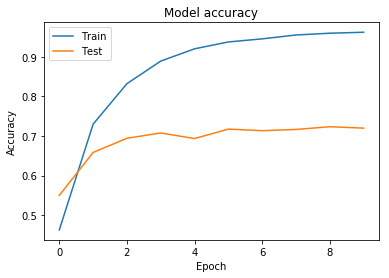

In [63]:
fig, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

It's obvious that we didn't achive a desent accuracy and the model overfits.

### Transfer Learning: Pre-trained Model Xception

Transfer learning is about borrowing CNN architecture with its pre-trained parameters from someone else. When we train our own data on the top of the pre-trained parameters, we can easily reach to the target accuracy.

The choosen model is Xception V1 model, with weights pre-trained on ImageNet.

On ImageNet, this model gets to a top-1 validation accuracy of 0.790 and a top-5 validation accuracy of 0.945. [https://keras.io/applications/#xception]

In [7]:
xception_base_model = Xception(input_shape=(img_width, img_height, 3), weights='imagenet', include_top=False, pooling='avg')
xception_model = Sequential()
xception_model.add(xception_base_model)
xception_model.add(Dense(512, activation='relu'))
#dropout layer, dropout randomly switches off some neurons in the network which forces the data to find new paths
xception_model.add(Dropout(0.5)) 
xception_model.add(Dense(n_classes, activation='softmax')) #class prediction(0–24)

# Say not to train first layer (Xception) model. It is already trained
xception_model.layers[0].trainable = False

#### Pre-trained Model Xception: Data preprocessing

In [9]:
# Pixel values rescaling from [0, 255] to [0, 1] interval
datagen_xception = ImageDataGenerator(rescale=1. / 255, preprocessing_function=preprocess_input)

# Retrieve images and their classes for train and validation sets
train_generator_xception = datagen_xception.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size_small)

validation_generator_xception = datagen_xception.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size_small)

Found 39857 images belonging to 25 classes.
Found 8644 images belonging to 25 classes.


#### Pre-trained Model Xception: Training

We compile the model with Adam. 

Adam is an optimization algorithm that can used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data.
Adam is different to classical stochastic gradient descent.
Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training.
A learning rate is maintained for each network weight (parameter) and separately adapted as learning unfolds.

Adam realizes the benefits of both Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp).

Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance).

Specifically, the algorithm calculates an exponential moving average of the gradient and the squared gradient, and the parameters beta1 and beta2 control the decay rates of these moving averages.

The initial value of the moving averages and beta1 and beta2 values close to 1.0 (recommended) result in a bias of moment estimates towards zero. This bias is overcome by first calculating the biased estimates before then calculating bias-corrected estimates.

Adam Configuration Parameters
- alpha. Also referred to as the learning rate or step size. The proportion that weights are updated (e.g. 0.001). Larger values (e.g. 0.3) results in faster initial learning before the rate is updated. Smaller values (e.g. 1.0E-5) slow learning right down during training
- beta1. The exponential decay rate for the first moment estimates (e.g. 0.9).
- beta2. The exponential decay rate for the second-moment estimates (e.g. 0.999). This value should be set close to 1.0 on problems with a sparse gradient (e.g. NLP and computer vision problems).
- epsilon. Is a very small number to prevent any division by zero in the implementation (e.g. 10E-8).

In [24]:
# Compile the model 
xception_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0005),
              metrics=['accuracy'])

In [11]:
xception_model_checkpointer = ModelCheckpoint(filepath='./models/xception_model_checkpoint.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
# early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

xception_model_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

hists = []

In [12]:
hist = xception_model.fit_generator(
    train_generator_xception,
    steps_per_epoch=train_samples // batch_size_small,
    epochs=1,
    verbose=1,
    callbacks=[xception_model_reducer, xception_model_checkpointer],
    validation_data=validation_generator_xception,
    validation_steps=validation_samples // batch_size_small)

hists.append(hist)

Epoch 1/1
2490/2491 [============================>.] - ETA: 0s - loss: 0.8485 - acc: 0.7751
Epoch 00001: val_acc improved from -inf to 0.81979, saving model to ./models/xception_model_checkpoint.h5
2491/2491 [==============================] - 1030s 413ms/step - loss: 0.8483 - acc: 0.7752 - val_loss: 0.6515 - val_acc: 0.8198


In [25]:
hist = xception_model.fit_generator(
    train_generator_xception,
    steps_per_epoch=train_samples // batch_size_small,
    epochs=10,
    verbose=1,
    callbacks=[xception_model_reducer, xception_model_checkpointer],
    validation_data=validation_generator_xception,
    validation_steps=validation_samples // batch_size_small)

hists.append(hist)

Epoch 1/10
2490/2491 [============================>.] - ETA: 0s - loss: 0.4536 - acc: 0.8697
Epoch 00001: val_acc improved from 0.81979 to 0.83542, saving model to ./models/xception_model_checkpoint.h5
2491/2491 [==============================] - 1061s 426ms/step - loss: 0.4535 - acc: 0.8697 - val_loss: 0.5887 - val_acc: 0.8354
Epoch 2/10
2490/2491 [============================>.] - ETA: 0s - loss: 0.3990 - acc: 0.8855
Epoch 00002: val_acc did not improve from 0.83542
2491/2491 [==============================] - 1002s 402ms/step - loss: 0.3991 - acc: 0.8855 - val_loss: 0.6039 - val_acc: 0.8343
Epoch 3/10
2490/2491 [============================>.] - ETA: 0s - loss: 0.3612 - acc: 0.8930
Epoch 00003: val_acc improved from 0.83542 to 0.85544, saving model to ./models/xception_model_checkpoint.h5
2491/2491 [==============================] - 1049s 421ms/step - loss: 0.3613 - acc: 0.8930 - val_loss: 0.5078 - val_acc: 0.8554
Epoch 4/10
2490/2491 [============================>.] - ETA: 0s - los

#### Pre-trained Model Xception: Evaluation

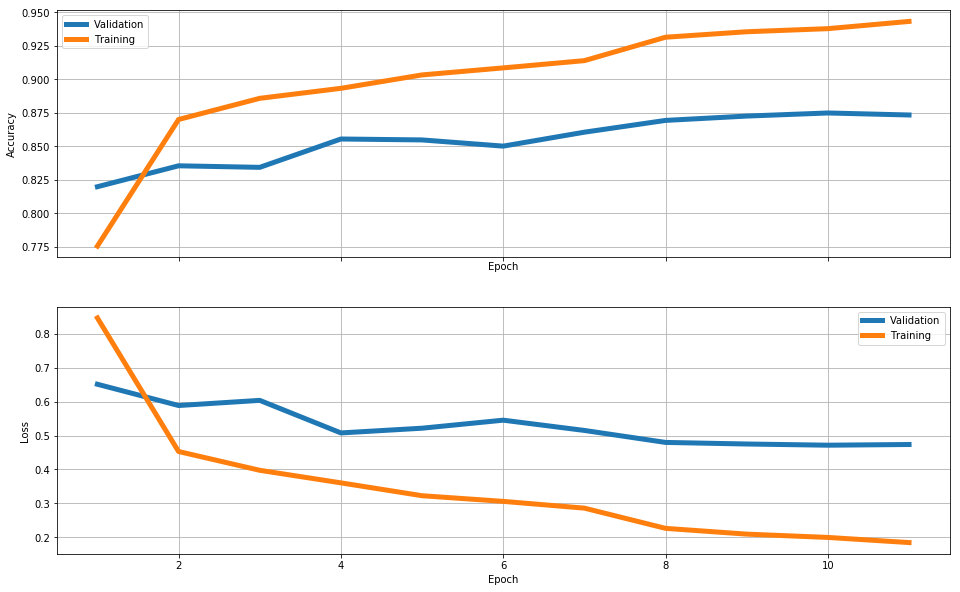

In [31]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_acc, lw=5, label='Validation')
axs[0].plot(hist_df.acc, lw=5, label='Training')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_loss, lw=5, label='Validation')
axs[1].plot(hist_df.loss, lw=5, label='Training')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
plt.show();

Let's try to improve the model by reducing the learning rate.

In [42]:
# Compile the model 
xception_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

In [43]:
hist = xception_model.fit_generator(
    train_generator_xception,
    steps_per_epoch=train_samples // batch_size_small,
    epochs=3,
    verbose=1,
    callbacks=[xception_model_reducer, xception_model_checkpointer],
    validation_data=validation_generator_xception,
    validation_steps=validation_samples // batch_size_small)

hists.append(hist)

Epoch 1/3
2490/2491 [============================>.] - ETA: 0s - loss: 0.1498 - acc: 0.9533
Epoch 00001: val_acc improved from 0.87488 to 0.87975, saving model to ./models/xception_model_checkpoint.h5
2491/2491 [==============================] - 1057s 424ms/step - loss: 0.1499 - acc: 0.9533 - val_loss: 0.4591 - val_acc: 0.8797
Epoch 2/3
2490/2491 [============================>.] - ETA: 0s - loss: 0.1549 - acc: 0.9523
Epoch 00002: val_acc improved from 0.87975 to 0.88299, saving model to ./models/xception_model_checkpoint.h5
2491/2491 [==============================] - 1035s 415ms/step - loss: 0.1550 - acc: 0.9523 - val_loss: 0.4401 - val_acc: 0.8830
Epoch 3/3
2490/2491 [============================>.] - ETA: 0s - loss: 0.1464 - acc: 0.9541
Epoch 00003: val_acc did not improve from 0.88299
2491/2491 [==============================] - 1027s 412ms/step - loss: 0.1475 - acc: 0.9538 - val_loss: 0.4471 - val_acc: 0.8808


We achived better accuracy but still our model overfits.

### Transfer Learning with feature extraction 

Now let's try another way to classify the images using a Convolutional Neural Network (in this case: VGG16) pre-trained on the Google ImageNet dataset. The Keras libary includes different types of CNN architectures like the used VGG16. Two other types would be for example ResNet or Inception. They are trained to be able to recognize 1.000 different categories of everyday things, such as species of dogs, cats, various household objects, vehicle types and so on. The ImageNet dataset includes all these daily objects. In order to classify the landmark, we apply ‘Transfer Learning’ strategy, such as feature extraction and fine-tuning, and use a VGG16 net that was pre-trained on ImageNet dataset. During the training we froze the first 15 layers of the CNNs, so the network can learn the weights for the images outside the ImageNet dataset’s images.

The architecture of VGG16: the input layer takes an image in the size of (224 x 224 x 3), and the output layer is a softmax prediction on 1000 classes. From the input layer to the last max pooling layer (labeled by 7 x 7 x 512) is regarded as the feature extraction part of the model, while the rest of the network is regarded as the classification part of the model.

<img src="./images/vgg16_architecture.png" width="400">

#### Bottleneck features 

First of all we use the remaining portion of the model as a feature extractor called ‘Bottleneck Features‘ (i.e. the last activation maps before the fully-connected layers in the original model). After that we train a small fully-connected network on the bottleneck features, so we get the classes as outputs for our problem. The following code only exists to get the classes and save the corresponding bottleneck features of the VGG16. Furthermore we use an ImageDataGenerator to rescale the images.

#### VGG16 + small multi-layer perceptron

In [8]:
# Pixel values rescaling from [0, 255] to [0, 1] interval
datagen_bottleneck = ImageDataGenerator(rescale=1./255)

# Retrieve images and their classes for train and validation sets
train_generator_bottleneck = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size_small,
        class_mode=None,
        shuffle=False)

validation_generator_bottleneck = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size_small,
        class_mode=None,
        shuffle=False)

Found 39857 images belonging to 25 classes.
Found 8644 images belonging to 25 classes.


In [9]:
model_vgg16 = VGG16(input_shape=(img_width, img_height, 3), include_top=False, weights='imagenet', pooling="max")

In [10]:
# bottleneck_features_train = model_vgg16.predict_generator(train_generator_bottleneck, train_samples // batch_size, verbose=1)
# np.save(open('./models/vgg16_bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

In [11]:
# bottleneck_features_validation = model_vgg16.predict_generator(validation_generator_bottleneck, validation_samples // batch_size, verbose=1)
# np.save(open('./models/vgg16_bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

In [39]:
train_data = np.load(open('./models/vgg16_bottleneck_features_train.npy', 'rb'))

validation_data = np.load(open('./models/vgg16_bottleneck_features_validation.npy', 'rb'))

In [40]:
train_labels = to_categorical(train_generator_bottleneck.classes.tolist()[:train_data.shape[:1][0]], num_classes=n_classes)
validation_labels = to_categorical(validation_generator_bottleneck.classes.tolist()[:validation_data.shape[:1][0]], num_classes=n_classes)

#### Train the top model

With the bottleneck features saved, now we are ready to train our top model. We create a small fully-connected network using the bottleneck features as input. To successfully do fine-tuning you shouldn’t put a randomly initialized fully-connected network on top of a pre-trained CNN, because that would destroy the learned weights in the convolutional base. In consequence of this, we will only be able to start fine-tuning alongside a trained top-level classifier.

In [41]:
model_top = Sequential()
model_top.add(Flatten(input_shape=train_data.shape[1:]))
model_top.add(Dense(512, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(n_classes, activation='softmax'))

In [42]:
model_top.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['accuracy'])

In [43]:
# Model saving callback
checkpointer_vgg16_bottleneck_features = ModelCheckpoint(filepath='./models/vgg16_bottleneck_features.h5', monitor='val_acc', verbose=1, save_best_only=True)

hists_vgg16_bottleneck_features = []

hist_vgg16_bottleneck_features = model_top.fit(
        train_data,
        train_labels,
        verbose=1,
        epochs=3, 
        batch_size=batch_size_small,
        callbacks=[checkpointer_vgg16_bottleneck_features],
        validation_data=(validation_data, validation_labels))

hists_vgg16_bottleneck_features.append(hist_vgg16_bottleneck_features)

Train on 39856 samples, validate on 8640 samples
Epoch 1/3
39728/39856 [============================>.] - ETA: 0s - loss: 0.9143 - acc: 0.7379
Epoch 00001: val_acc improved from -inf to 0.78681, saving model to ./models/vgg16_bottleneck_features.h5
39856/39856 [==============================] - 13s 336us/step - loss: 0.9133 - acc: 0.7382 - val_loss: 0.7210 - val_acc: 0.7868
Epoch 2/3
39664/39856 [============================>.] - ETA: 0s - loss: 0.5086 - acc: 0.8507
Epoch 00002: val_acc improved from 0.78681 to 0.81366, saving model to ./models/vgg16_bottleneck_features.h5
39856/39856 [==============================] - 12s 308us/step - loss: 0.5083 - acc: 0.8508 - val_loss: 0.6165 - val_acc: 0.8137
Epoch 3/3
39792/39856 [============================>.] - ETA: 0s - loss: 0.4279 - acc: 0.8720
Epoch 00003: val_acc improved from 0.81366 to 0.83900, saving model to ./models/vgg16_bottleneck_features.h5
39856/39856 [==============================] - 12s 297us/step - loss: 0.4275 - acc: 0.872

In [44]:
# Early stopping
early_stopping_vgg16_bottleneck_features = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

hist_vgg16_bottleneck_features =  model_top.fit(
        train_data,
        train_labels,
        verbose=2,
        epochs=30, 
        batch_size=batch_size_small,
        callbacks=[checkpointer_vgg16_bottleneck_features, early_stopping_vgg16_bottleneck_features],
        validation_data=(validation_data, validation_labels))

hists_vgg16_bottleneck_features.append(hist_vgg16_bottleneck_features)

Train on 39856 samples, validate on 8640 samples
Epoch 1/30

Epoch 00001: val_acc improved from 0.83900 to 0.84734, saving model to ./models/vgg16_bottleneck_features.h5
 - 10s - loss: 0.3847 - acc: 0.8854 - val_loss: 0.5277 - val_acc: 0.8473
Epoch 2/30

Epoch 00002: val_acc improved from 0.84734 to 0.84965, saving model to ./models/vgg16_bottleneck_features.h5
 - 11s - loss: 0.3524 - acc: 0.8921 - val_loss: 0.5109 - val_acc: 0.8497
Epoch 3/30

Epoch 00003: val_acc did not improve from 0.84965
 - 11s - loss: 0.3422 - acc: 0.8970 - val_loss: 0.5238 - val_acc: 0.8493
Epoch 4/30

Epoch 00004: val_acc improved from 0.84965 to 0.85081, saving model to ./models/vgg16_bottleneck_features.h5
 - 11s - loss: 0.3168 - acc: 0.9037 - val_loss: 0.5350 - val_acc: 0.8508
Epoch 5/30

Epoch 00005: val_acc improved from 0.85081 to 0.85521, saving model to ./models/vgg16_bottleneck_features.h5
 - 11s - loss: 0.3023 - acc: 0.9087 - val_loss: 0.5023 - val_acc: 0.8552
Epoch 6/30

Epoch 00006: val_acc improve

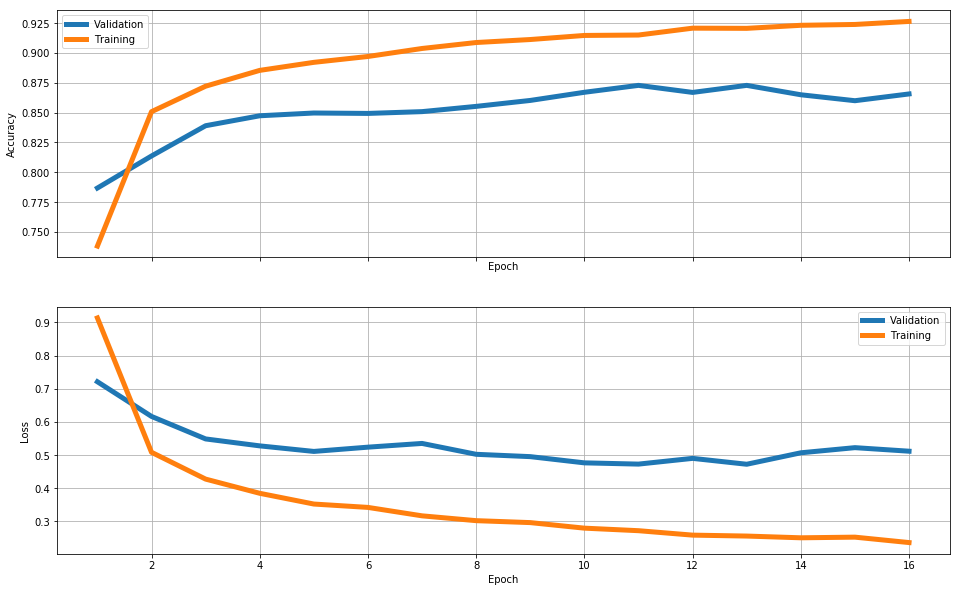

In [45]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists_vgg16_bottleneck_features], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_acc, lw=5, label='Validation')
axs[0].plot(hist_df.acc, lw=5, label='Training')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_loss, lw=5, label='Validation')
axs[1].plot(hist_df.loss, lw=5, label='Training')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
plt.show();

#### Fine-tuning the top layers of a pre-trained network (VGG16)

This model is not yet performing well, because the weights are still the weights of the ImageNet – in conclusion, so we have to fine-tune it. Alongside the top-level-classifier we fine-tune the last two convolutional parts and freeze the first 15 layer. First we have to load the old weights and build the convolutional base of the VGG16. After that we load the weights of our top-model previously defined and freeze the layers of the model up to layer 15. A 'fit_generator' helps to feed the data to our RAM in batches. Without it you will get an 'out-of-memory-error'.

In [10]:
base_model_vgg16 = VGG16(input_shape=(img_width, img_height, 3), include_top=False, weights='imagenet', pooling="max")

In [11]:
top_model = Sequential()

top_model.add(Flatten(input_shape=base_model_vgg16.output_shape[1:]))
top_model.add(Dense(512, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(n_classes, activation='softmax'))

top_model.load_weights('./models/vgg16_bottleneck_features.h5')

In [12]:
vgg16_model_tuning = Model(inputs=base_model_vgg16.input, outputs=top_model(base_model_vgg16.output))

In [16]:
vgg16_model_tuning.layers

In [17]:
for layer in vgg16_model_tuning.layers[:15]:
    layer.trainable = False

In [15]:
datagen_vgg16 = ImageDataGenerator(rescale=1./255)


train_generator_vgg16 = datagen_vgg16.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size_small)

validation_generator_vgg16 = datagen_vgg16.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size_small)

Found 39857 images belonging to 25 classes.
Found 8644 images belonging to 25 classes.


In [13]:
vgg16_model_tuning.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

In [24]:
# Model saving callback
checkpointer_vgg16_tuning = ModelCheckpoint(filepath='./models/vgg16_tining.h5', monitor='val_acc', verbose=1, save_best_only=True)

reducer_vgg16_tuning = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

hists_vgg16_tuning  = []

hist_vgg16_tuning  = vgg16_model_tuning.fit_generator(
    train_generator_vgg16,
    steps_per_epoch=train_samples // batch_size_small,
    verbose=1,
    epochs=1, 
    callbacks=[checkpointer_vgg16_tuning, reducer_vgg16_tuning],
    validation_data=validation_generator_vgg16,
    validation_steps=validation_samples // batch_size_small
)

hists_vgg16_tuning.append(hist_vgg16_tuning)

Epoch 1/1
2490/2491 [============================>.] - ETA: 0s - loss: 0.2306 - acc: 0.9376
Epoch 00001: val_acc improved from -inf to 0.93252, saving model to ./models/vgg16_tining.h5
2491/2491 [==============================] - 1530s 614ms/step - loss: 0.2305 - acc: 0.9376 - val_loss: 0.2787 - val_acc: 0.9325


In [41]:
hist_vgg16_tuning  = vgg16_model_tuning.fit_generator(
    train_generator_vgg16,
    steps_per_epoch=train_samples // batch_size_small,
    verbose=1,
    epochs=5, 
    callbacks=[checkpointer_vgg16_tuning, reducer_vgg16_tuning],
    validation_data=validation_generator_vgg16,
    validation_steps=validation_samples // batch_size_small
)

hists_vgg16_tuning.append(hist_vgg16_tuning)

Epoch 1/5
2490/2491 [============================>.] - ETA: 0s - loss: 0.1144 - acc: 0.9703
Epoch 00001: val_acc improved from 0.93252 to 0.95382, saving model to ./models/vgg16_tining.h5
2491/2491 [==============================] - 1931s 775ms/step - loss: 0.1144 - acc: 0.9703 - val_loss: 0.1851 - val_acc: 0.9538
Epoch 2/5
2490/2491 [============================>.] - ETA: 0s - loss: 0.0935 - acc: 0.9772
Epoch 00002: val_acc did not improve from 0.95382
2491/2491 [==============================] - 1919s 770ms/step - loss: 0.0935 - acc: 0.9772 - val_loss: 0.2242 - val_acc: 0.9451
Epoch 3/5
2490/2491 [============================>.] - ETA: 0s - loss: 0.0662 - acc: 0.9842
Epoch 00003: val_acc improved from 0.95382 to 0.95532, saving model to ./models/vgg16_tining.h5
2491/2491 [==============================] - 1256s 504ms/step - loss: 0.0661 - acc: 0.9842 - val_loss: 0.2175 - val_acc: 0.9553
Epoch 4/5
2490/2491 [============================>.] - ETA: 0s - loss: 0.0616 - acc: 0.9858
Epoch 

In [45]:
hist_vgg16_tuning  = vgg16_model_tuning.fit_generator(
    train_generator_vgg16,
    steps_per_epoch=train_samples // batch_size_small,
    verbose=1,
    epochs=3, 
    callbacks=[checkpointer_vgg16_tuning, reducer_vgg16_tuning],
    validation_data=validation_generator_vgg16,
    validation_steps=validation_samples // batch_size_small
)

hists_vgg16_tuning.append(hist_vgg16_tuning)

Epoch 1/3
2490/2491 [============================>.] - ETA: 0s - loss: 0.0209 - acc: 0.9955
Epoch 00001: val_acc did not improve from 0.96921
2491/2491 [==============================] - 1387s 557ms/step - loss: 0.0209 - acc: 0.9955 - val_loss: 0.1960 - val_acc: 0.9691
Epoch 2/3
2490/2491 [============================>.] - ETA: 0s - loss: 0.0144 - acc: 0.9965
Epoch 00002: val_acc did not improve from 0.96921
2491/2491 [==============================] - 1505s 604ms/step - loss: 0.0144 - acc: 0.9965 - val_loss: 0.3262 - val_acc: 0.9567
Epoch 3/3
2490/2491 [============================>.] - ETA: 0s - loss: 0.0207 - acc: 0.9957
Epoch 00003: val_acc did not improve from 0.96921
2491/2491 [==============================] - 1391s 559ms/step - loss: 0.0207 - acc: 0.9957 - val_loss: 0.2284 - val_acc: 0.9645


#### Evaluation of the fine-tuned model

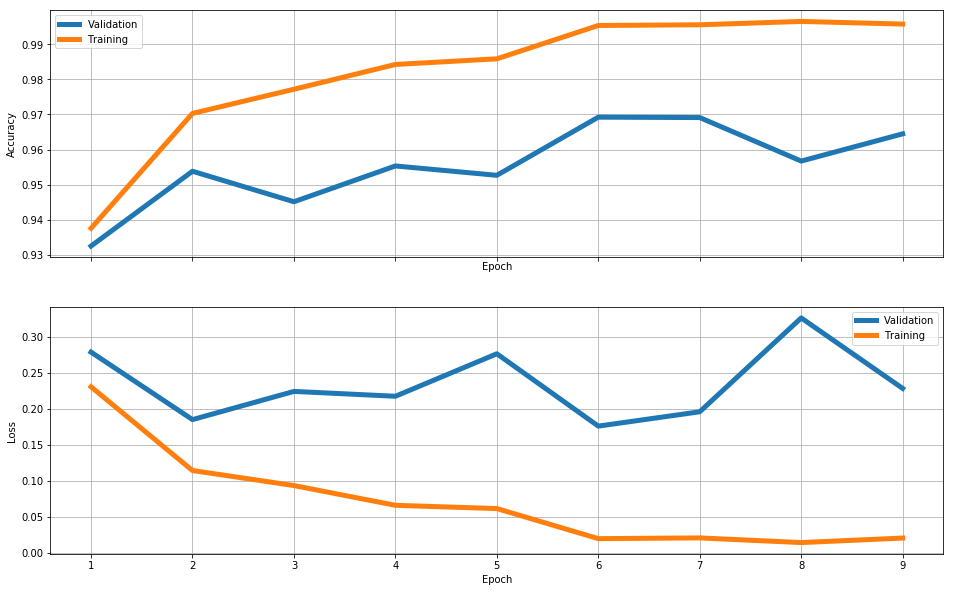

In [46]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists_vgg16_tuning], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_acc, lw=5, label='Validation')
axs[0].plot(hist_df.acc, lw=5, label='Training')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_loss, lw=5, label='Validation')
axs[1].plot(hist_df.loss, lw=5, label='Training')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
plt.show();

In [17]:
# vgg16_model_tuning.load_weights("./models/vgg16_tining.h5")

In [18]:
vgg16_model_tuning.evaluate_generator(validation_generator_vgg16, validation_samples / batch_size_small, verbose=1)

541/540 [==============================] - 238s 440ms/step


[0.17596535271980915, 0.9692272096251735]

#### Evaluation on flickr images  

For additional evaluation I downloaded 1k images from https://www.flickr.com/ for testing. 

In [39]:
test_data_dir = './data/test'
test_generator_vgg16 = datagen_vgg16.flow_from_directory(
        test_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size_small)

Found 1079 images belonging to 25 classes.


In [40]:
vgg16_model_tuning.evaluate_generator(test_generator_vgg16, test_generator_vgg16.samples / batch_size_small, verbose=1)

68/67 [==============================] - 21s 303ms/step


[1.5709205656015721, 0.8313253013153006]

The accuracy is lower but most of the images are harder than our test and evaluation datasets.

<b> File "./models/vgg16_tining.h5" can be downloaded from https://drive.google.com/open?id=13Q6cXoHM3-VElW-vUe2P9g2oHdNYS-sT <b>

###  Predictions Visualization 

Now let's see some image predictions. We will use DELF to draw matches of the image features and randomly choosen image from training dataset of the predicted class. Also based on the inliers we will draw a box around the area of the predicted landmark.

DELF: DEep Local Features detects and describes semantic local features which can be geometrically verified between images showing the same object instance. The pre-trained model released here has been optimized for landmark recognition, so expect it to work well in this area. [https://github.com/tensorflow/models/tree/master/research/delf]

We also define some additional functions in utils/delf.py to get the coordinates of the area with inliers.

In [50]:
def decode_predictions(original_array, model):
    predictions = model.predict(original_array)
    return landmark_classes[predictions.argmax()], predictions.max()

def load_image(image_path):
    original_image = Image.open(image_path).resize((img_width, img_height))
    original_array = np.expand_dims(np.array(original_image), 0)

    return original_array

def get_correct_predicted_image_for_class(class_name, model):
    dir_path = os.path.join(train_data_dir, class_name)
    filename = random.choice(os.listdir(dir_path))
    image = os.path.join(dir_path, filename)
    original_array = load_image(image)
    category, proba = decode_predictions(original_array, vgg16_model_tuning)
    if(class_name == category):
        return image
    else:
        return get_correct_predicted_image_for_class(class_name, model)

In [21]:
test_images_filenames = [
    './data/validation/arc_de_triomphe/2195175040.jpg',
    './data/validation/arc_de_triomphe/6045281055.jpg',
    './data/validation/arc_de_triomphe/3766337011.jpg',
    './data/validation/arc_de_triomphe/3769030741.jpg',
    './data/validation/big_ben/3947650648.jpg',
    './data/validation/big_ben/4860593771.jpg',
    './data/validation/big_ben/194760399.jpg',
    './data/validation/big_ben/490063476.jpg'
]

test_images_delf_features = get_features(test_images_filenames)

In [30]:
train_images_filenames = []
for line, filename in enumerate(test_images_filenames):    
    original_array = load_image(filename)
    category, proba = decode_predictions(original_array, vgg16_model_tuning)
    train_image_filename = get_correct_predicted_image_for_class(category, vgg16_model_tuning)
    train_images_filenames.append(train_image_filename)
    
train_images_delf_features = get_features(train_images_filenames)

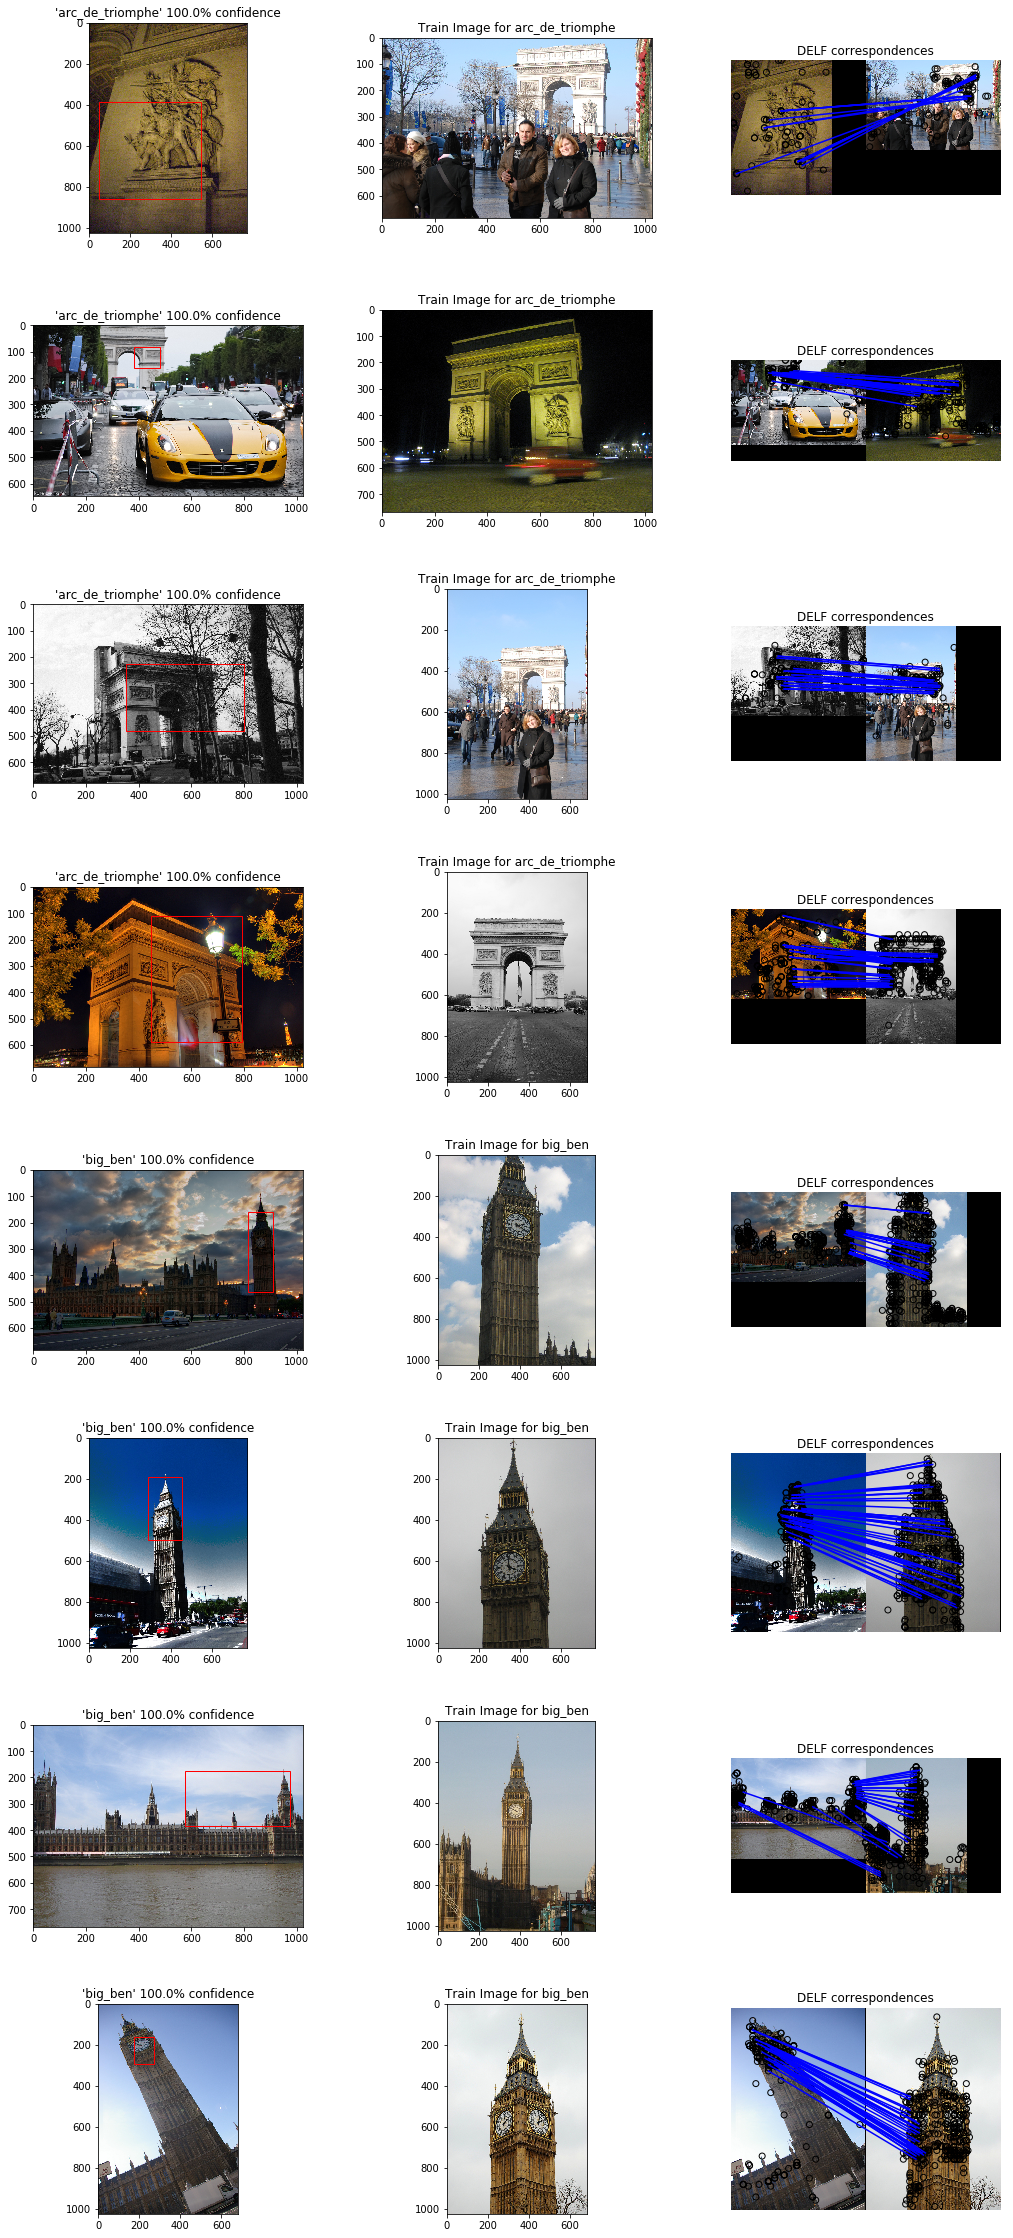

In [34]:
n_lines = len(test_images_filenames)
plt.figure(figsize = (15, 4 * n_lines))

for line, filename in enumerate(test_images_filenames):    
    original_array = Image.open(filename)
    category, proba = decode_predictions(load_image(filename), vgg16_model_tuning)
    image_title = "'%s' %.1f%% confidence" % (category, proba * 100)
    
    train_image_filename = train_images_filenames[line]
    results_dict = {}
    results_dict[filename] = test_images_delf_features[filename]
    results_dict[train_image_filename] = train_images_delf_features[train_image_filename]
    min_x, max_x, min_y, max_y = get_delf_features_inliners_coordinates(results_dict, filename, train_image_filename)
   
    ax1 = plt.subplot(n_lines, 3, 3 * line + 1)

    # Display the image
    ax1.imshow(original_array)

    # Create a Rectangle patch
    rect = patches.Rectangle((min_x,min_y),max_x-min_x,max_y-min_y,linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax1.add_patch(rect)
    plt.title(image_title)
    
    image_prediction_array = Image.open(train_image_filename)
    ax2 = plt.subplot(n_lines, 3, 3 * line + 2)
    ax2.imshow(image_prediction_array)
    plt.title("Train Image for %s" % category)
    
    ax = plt.subplot(n_lines, 3, 3 * line + 3)
    match_images(results_dict, filename, train_image_filename, ax)
    

plt.tight_layout(pad = 4)

### Conclusion

We tried different approaches to train a NN(Neural Network) to recognize 25 landmarks. Our best model achived 97% accuracy on validation set. We applied 'Transfer Learning' strategy with feature extraction('bottleneck features') using pre-trained VGG16 on ImageNet with top-model classifier and fine-tuning the model by freezing the first 15 layers. 
Future work will be adding more landmark classes and data, and implementing NN for detection the landmark on the images or videos.

### References

https://www.tensorflow.org/

https://keras.io/

https://softuni.bg/trainings/1921/deep-learning-november-2018

https://github.com/vfaramond/landmarks-recognition/

https://www.novatec-gmbh.de/en/landmark-recognition/

https://medium.com/@franky07724_57962/using-keras-pre-trained-models-for-feature-extraction-in-image-clustering-a142c6cdf5b1

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

https://www.kaggle.com/dansbecker/transfer-learning

https://archive.codeplex.com/?p=landmark3d

https://github.com/tensorflow/models/tree/master/research/delf

 https://www.flickr.com/